This Notebook contains the initial investigation of the datset contained within the PTB Diagnostic ECG Database: https://www.physionet.org/content/ptbdb/1.0.0/ . Can talk about database......


Date: 14/11/2023


I am expecting each .dat data file read in to contain information relating to 12 leads, each corresponding to nodes placed at different locations on the patients chest. Here I have focussed on the leads closest to the Heart, namely v1 - v6. 
The sampling frequency for each lead is 1000Hz. 

The data is stored in binary form so the first step is to read this in and then place it in a maleable datbase. I had not come across working with binary datasets before so ChatGPT was used to help me do this.

In [1]:
import pandas as pd #for data frame
import struct #for binary conversion

#first file used as an example
file_path = 'ptb-diagnostic-ecg-database-1.0.0/ptb-diagnostic-ecg-database-1.0.0/patient001/s0010_re.dat'


binary_data = []

# Read the binary data from the file
with open(file_path, 'rb') as file:
    # Assuming each value in the binary data is a 16-bit integer
    while True:
        # Read 2 bytes (16 bits) from the file as a binary integer
        binary_int = file.read(2)
        if not binary_int:
            break  # End of file reached
        value = struct.unpack('<h', binary_int)[0]
        # Append the value to the list
        binary_data.append(value)

# Create a DataFrame from the binary data
df = pd.DataFrame({'ECG_Data': binary_data})

print(df)


        ECG_Data
0           -489
1           -458
2             31
3            474
4           -260
...          ...
460795       164
460796       118
460797      -168
460798      -249
460799      -333

[460800 rows x 1 columns]


We can see that the ECG data contains 460800 values of voltage. I then plotted this data for visual analysis.

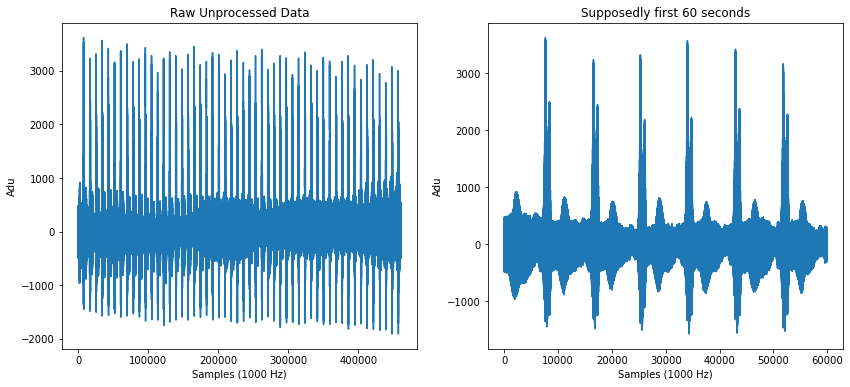

In [2]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

ax1.plot(df)
ax1.set_xlabel('Samples (1000 Hz)')
ax1.set_ylabel('Adu')
ax1.set_title('Raw Unprocessed Data')

#if 1000 Hz expect 60 seconds to be the first 60000 samples
ax2.plot(df.head(60000))
ax2.set_xlabel('Samples (1000 Hz)')
ax2.set_ylabel('Adu')
ax2.set_title('Supposedly first 60 seconds')
plt.show()

As the plots above were not as expected, I further looked into the documentation and discovered that each of the 12 leads were recorded simulataneoulsy such that out of the 460800 data points within this file, each lead has 460800/12 = 38400 samples.
I then decided to split the dataset into each of the 12 leads to investigate each one individually. Here I have focussed on leads v1 - v6 as they are the leads placed closest to the heart and so theoretically should have the best signal to noise ratio. Here I also learnt that to convert to mV I needed to divide by 2000???

In [3]:
import numpy as np

lead_names = ["i", "ii", "iii", "avr", "avl", "avf", "v1", "v2", "v3", "v4", "v5", "v6"]

# Initialize a list to store data DataFrames
lead_dataframes = []

# Loop through the lead names and create DataFrames
for lead_name in lead_names:
    with open(file_path, 'rb') as f:
        data = f.read(2)  # Read 2 bytes (16 bits) at a time
        lead_data = []

        while data:
            value = struct.unpack('<h', data)[0]  # Interpret as a 16-bit signed integer
            lead_data.append(value / 2000)  # Convert to mV
            data = f.read(2)

        lead_df = pd.DataFrame(lead_data, columns=[lead_name])
        lead_dataframes.append(lead_df)

# Concatenate the lead DataFrames into one DataFrame
ecg_dataframe = pd.concat(lead_dataframes, axis=1)

# Generate timestamps based on the sampling rate
sampling_rate = 1000  # 1000 Hz
total_samples = len(lead_dataframes[0])
time_values = np.arange(0, total_samples) / sampling_rate

# Add timestamps as an index in the DataFrame
ecg_dataframe["Time (s)"] = time_values

The above code reads in the same file as previous but this time, stores the data in a dataframe with each column referring to a lead, a time axis added in seconds and voltages converted to mV. Although the data is the same in every column this allows manipulation of multiple leads at once. 

The code below allows investigation of each lead seperately to show what this looks like now I have plotted 'v1'.

In [4]:
# Define the sample where the "v1" to "v6" channels become relevant
  # Adjust this value as needed based on your data
dt = 38400

# Initialize an empty dictionary to store the DataFrames for each channel
v_channel_dataframes = {}

# Loop through the channel names "v1" to "v6" and create a DataFrame for each
for i, channel_name in enumerate(["i", "ii", "iii", "avr", "avl", "avf", "v1", "v2", "v3", "v4", "v5", "v6"]):
    # Select the corresponding channel and create a new DataFrame
    selected_channel_df = ecg_dataframe[channel_name].iloc[i*dt:(i+1)*dt]
    
    # Store the DataFrame in the dictionary with the channel name as the key
    v_channel_dataframes[channel_name] = selected_channel_df
    


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

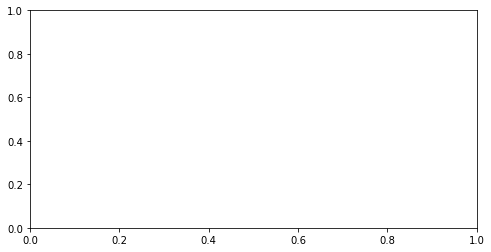

In [5]:
v_start_sample = 230400

fig1, ax1 = plt.subplots(1, 1, figsize = (8, 4))
ax1.plot(ecg_dataframe["Time (s)"].iloc[v_start_sample:v_start_sample+dt], v_channel_dataframes["v1"])
ax1.set_title('v1')
ax1.set_xlabel('Times (s)')
ax1.set_ylabel('V')
plt.show()

As can be seen above this is still not the desired shape so further investigation commenced in terms of next steps. Although I was unsuccesful in finding exact information for this database, I noticed that in many papers in the data-preprocessing section they mention removing the low frequency aspects, noise and baseline removal using a butterworth filter so I attmepted this.

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

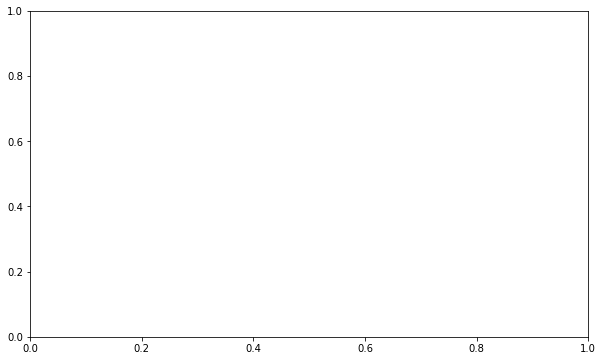

In [6]:
from scipy.signal import butter, filtfilt

fs = 1000  # Sampling frequency in Hz
cutoff_frequency = 40  # Cutoff frequency in Hz - to be investigated further??

# Design a Butterworth low-pass filter
order = 2  # Filter order, also to be investigated further
b, a = butter(order, cutoff_frequency, btype='low', analog=False, fs=fs) #/(o.5*fs)

# Apply the filter to the "v1" channel
v1_filtered = filtfilt(b, a, v_channel_dataframes["v1"])

# Plot the original and filtered signals
plt.figure(figsize=(10, 6))
plt.plot(ecg_dataframe["Time (s)"].iloc[v_start_sample:v_start_sample+dt], v_channel_dataframes["v1"], label="Original v1")
plt.plot(ecg_dataframe["Time (s)"].iloc[v_start_sample:v_start_sample+dt], v1_filtered, label="Filtered v1")
plt.title("Original vs Filtered v1")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.legend()
plt.show()

The above shows that after applying the butterworth filter we appear to get an ECG more in line with what expected. However I am still wary as this does still seem to suggest one beat every 10 seconds. I hope that this will be fixed through more investigation into the workings of this filter.

I shall now attempt to automate all the above code to allow for quick analysis of different files - see automated ECG

In [ ]:
#look at extended kalman filter and other options instead of butterworth filter.